### Демонстрационный файл

> Программа выполняет классификацию корпуса текстов 
> на основе заготовленных входных и выходных векторов
> в БД SQLite. Настройки пути файла БД и параметры 
> обучения нейронной сети задаются файлом param.json


**Подключение внешних библиотек:**

In [1]:
import sys
sys.path.append('..')
from DbInteraction import DbInteraction
from Param import Param
import time
import json
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

**Инициализация работы с БД:**

In [2]:
p = Param('../param.json') #инициализация класса с параметрами работы
pathToDB = p.getPathToDBForReport()
db = DbInteraction() #иниц. класса для работы с БД
db.initNNAnalysis(pathToDB) # отправка в него пути к БД
db.addInfo() # добавить новую строку
actualNumberOfData = db.getInfoSize() # узнать номер последней строки
print('Готово!')

Готово!


**Получение дополнительных параметров для работы и отчета:**

In [3]:
t = time.localtime()
compilationTime = "{0}.{1}.{2} {3}:{4}".format(t.tm_year, t.tm_mon, 
                                               t.tm_mday, t.tm_hour, 
                                               t.tm_min)
inputSize = db.getInfoData('dictionarySize', 1)[0][0]
outputSize = db.getInfoData('numOfTopics', 1)[0][0]
corpusSize = db.getInfoData('numOfTexts', 1)[0][0]
print('Готово!')

Готово!


**Настройка объекта для последовательного извлечения 
входных и выходных данных:**

In [4]:
c = db.getConnectionData()
ds = tf.data.Dataset.from_generator(
    db.generator(corpusSize, db.getDataCorpusName(), 'inputVector', 'outputVector'),
    output_types=(tf.float64, tf.float64),
    output_shapes=(tf.TensorShape((inputSize, )), tf.TensorShape((outputSize, ))))
print('Готово!')

Готово!


**Разделение данных на обучающую и тестовую:**

In [5]:
ds = ds.shuffle(buffer_size=corpusSize,
                reshuffle_each_iteration=True)
trainSize = int(corpusSize*p.getTrainPercentage()/100)
ds_train = ds.take(trainSize)
ds_val = ds.skip(trainSize)
ds = None

ds_train = ds_train.batch(30)
ds_val = ds_val.batch(30)
print('Готово!')

Готово!


**Формирование и подготовка нейронной сети:**

In [6]:
model = tf.keras.Sequential()

model.add(layers.Dense(inputSize, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(outputSize, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print('Готово!')

Готово!


**Начало процесса обучения сети:**

In [7]:
startTime = time.time() 
history = model.fit(ds_train,
                    epochs=100,
                    validation_data=ds_val)
endTime = time.time() 
print('Готово!')

Epoch 1/100
1/1 [==============================] - 1s 570ms/step - loss: 1.3872 - categorical_accuracy: 0.2857 - val_loss: 5.4315 - val_categorical_accuracy: 0.4286
Epoch 2/100
1/1 [==============================] - 0s 71ms/step - loss: 4.8069 - categorical_accuracy: 0.3571 - val_loss: 1.4919 - val_categorical_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 78ms/step - loss: 3.4647e-04 - categorical_accuracy: 1.0000 - val_loss: 2.9011e-04 - val_categorical_accuracy: 1.0000
Epoch 45/100
1/1 [==============================] - 0s 74ms/step - loss: 2.9955e-04 - categorical_accuracy: 1.0000 - val_loss: 2.8674e-04 - val_categorical_accuracy: 1.0000


Epoch 46/100
1/1 [==============================] - 0s 73ms/step - loss: 1.8840e-04 - categorical_accuracy: 1.0000 - val_loss: 1.5373e-04 - val_categorical_accuracy: 1.0000
Epoch 47/100
1/1 [==============================] - 0s 76ms/step - loss: 1.0243e-05 - categorical_accuracy: 1.0000 - val_loss: 1.5020e-05 - val_categorical_accuracy: 1.0000
Epoch 93/100


1/1 [==============================] - 0s 76ms/step - loss: 9.1024e-06 - categorical_accuracy: 1.0000 - val_loss: 4.8876e-06 - val_categorical_accuracy: 1.0000
Epoch 94/100
1/1 [==============================] - 0s 72ms/step - loss: 6.9567e-06 - categorical_accuracy: 1.0000 - val_loss: 7.0844e-06 - val_categorical_accuracy: 1.0000
Epoch 100/100
1/1 [==============================] - 0s 63ms/step - loss: 8.0040e-06 - categorical_accuracy: 1.0000 - val_loss: 3.9850e-06 - val_categorical_accuracy: 1.0000
Готово!


**Построение графиков для отчета:**

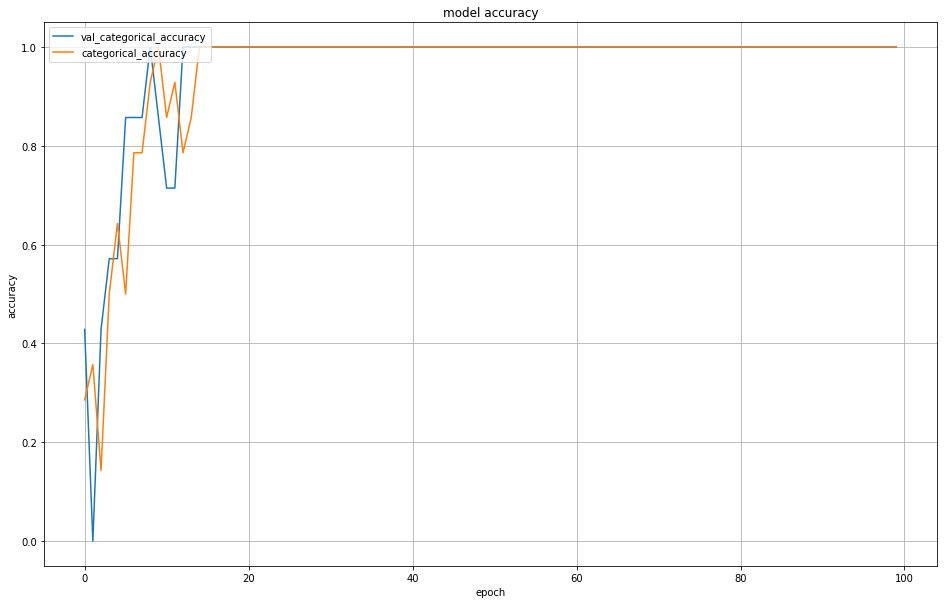

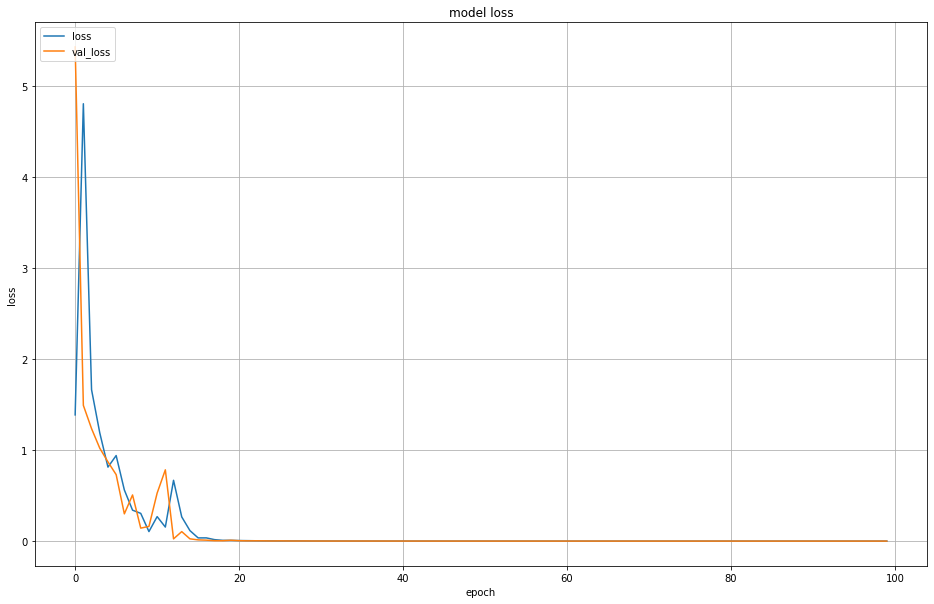

In [8]:
#summarize history for accuracy
plt.figure(figsize=(16, 10))
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_categorical_accuracy', 'categorical_accuracy'], loc='upper left')
plt.grid(True)
plt.show()

#summarize history for loss
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.grid(True)
plt.show()

**Подготовка данных для отчета:**

In [11]:
resultFull = json.dumps(history.history)
resultFull = resultFull.replace('"', '""') 
catAccArray = history.history['categorical_accuracy']
resultVal1 = json.dumps(catAccArray[len(catAccArray)-1]) 
# <- last model accuracy categorical_accuracy
valCatAccArray = history.history['val_categorical_accuracy']
resultVal2 = json.dumps(valCatAccArray[len(valCatAccArray)-1]) 
# <- last val accuracy val_categorical_accuracy
learningTime = json.dumps(endTime-startTime)
compilationTime2 = "{0}-{1}-{2} {3}-{4}".format(t.tm_year, t.tm_mon, 
                                               t.tm_mday, t.tm_hour, 
                                               t.tm_min)
nameOfSavedModel = "model_"+p.readName()+"_"+compilationTime2+".h5"
neuralNetworkStruct = json.dumps(nameOfSavedModel)
neuralNetworkStruct = neuralNetworkStruct.replace('"', '') 
model.save("../savedModels/"+nameOfSavedModel)
print('Готово!')

Готово!


**Сохранение результатов работы программы в БД:**

In [12]:
db.updateInfo('resultVal1', resultVal1, actualNumberOfData)
db.updateInfo('resultVal2', resultVal2, actualNumberOfData)
db.updateInfo('resultFull', resultFull, actualNumberOfData)
db.updateInfo('learningTime', learningTime, actualNumberOfData)
db.updateInfo('compilationTime', compilationTime, actualNumberOfData)
db.updateInfo('neuralNetworkStruct', neuralNetworkStruct, actualNumberOfData)
print('Готово!')

Готово!
